# Performance Visualization
In this notebook we'll visualize the performance of various programs on variying hardware architectures. 


## Basic Analysis

### Tables 
1. Table with each type of processor with best unroll factor, and how much it beats the other unroll factors by


### Bar charts / Color Scatter Plots (depending on which looks better)
We'll use barcharts when we have 2 categorical variables and cycles as the y axis

1. (N way, unrolls) vs cycles histogram # (N-way = 3, ROB size = 32, RS size = 16, Cache size = 64)
2. (ROB size, unrolls) vs cycles h
    2a. (ROB size, unrolls) vs rob hazards
3. (RS size, unrolls) vs cycles
4. (Cache size, unrolls) vs cycles
    4a. (Cache size, unrolls) vs cache misses


## Tree Map
Heirarchical representation to easily visualize what did the best
N -> ROB size -> RS size -> cache size and look at the best unroll for each one + % optimization improvement

## Colored Scatter Plots
1. ROB - IPL vs cycles (color for each unroll, shape for each rob)
2. Cache_size - (IPL/2) vs cycles (color for each unroll, shape for each rob)
3. ROB_SIZE / (IPL / UNROLL COUNT) vs cycles



## Heuristic Comparisions
1. Always take the max unroll
2. Always just do 1 unroll
3. Unroll = N
4. max unroll that makes IPL < ROB size
5. unroll = min(rob_size, cache_size*2)

Rows = processor config, Columns = heuristics, values = average % improvement from baseline 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
HARDWARE_COLUMNS = ['N', 'ROB size', 'RS size', 'Cache Size', 'Memory Latency', 'Branch Type']
OPTIMIZATIONS = ['Unrolls', 'Optimization Lvl']
RESULTS = ['Cycles', 'Instructions', 'Icache hit', 'Dcache hit', 'ROB hzrds', 'RS hzrds', 'LSQ hzrds']
METADATA = ['IPL', 'N-iterations']

In [31]:
def read_csv(name):
    results_csv = f'data/{name}_results.csv'
    metadata_csv = f'data/metadata/{name}.csv'
    
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    
    df['Cycles'] = df['Cycles'].astype(float)
    df['hardware_id']= df[HARDWARE_COLUMNS].astype(str).agg('-'.join, axis=1)    
    
    def pct_cycle_change(dframe):
        base_cycle_val = float(dframe[(dframe['Unrolls'] == 1) & (dframe['Optimization Lvl'] == 8)]['Cycles'])
        base_rob_hzrd_val = float(dframe[(dframe['Unrolls'] == 1) & (dframe['Optimization Lvl'] == 8)]['ROB hzrds'])
        base_icache_val = float(dframe[(dframe['Unrolls'] == 1) & (dframe['Optimization Lvl'] == 8)]['Icache hit'])
        base_branch_hit_val = float(dframe[(dframe['Unrolls'] == 1) & (dframe['Optimization Lvl'] == 8)]['Branch hit'])        
        dframe['speedup'] = -100 * (dframe['Cycles'] - base_cycle_val) / base_cycle_val
#         dframe['cycle_pct'] = 100 * (1 - base_cycle_val / dframe['Cycles'])
        dframe['rob_pct'] = 100 * (dframe['ROB hzrds'] - base_rob_hzrd_val) / base_rob_hzrd_val
#         dframe['icache_pct'] = 100 * (dframe['Icache hit'] - base_icache_val)     
        dframe['icache_pct'] = 100 * dframe['Icache hit'] 
        dframe['branch_pct'] = 100 * (1-dframe['Branch hit'])
        
        
        return dframe
    
    df = df.groupby('hardware_id').apply(pct_cycle_change)    
    
    metadata_df = pd.read_csv(metadata_csv)
    
    new_df = pd.merge(df, metadata_df,  how='left', left_on=['Unrolls','Optimization Lvl'], right_on = ['Unrolls','Optimization Lvl'])    
    
    return new_df

In [32]:
# rv32_parallel_results = pd.read_csv('data/rv32_max_results.csv')
# rv32_parallel_results = rv32_parallel_results.dropna()
# rv32_parallel_results.columns = rv32_parallel_results.columns.str.strip()


# for idx, row in rv32_parallel_results.iterrows():
#     print(f'idx: {idx}, cycles: ', row['Cycles'])  
#     print('Cycles: ', float(row['Cycles']))    

In [33]:
fc_forward_results = read_csv('fc_forward')
rv32_parallel_results = read_csv('rv32_parallel')
rv32_fib_results = read_csv('rv32_fib')
rv32_copy_results = read_csv('rv32_copy')
rv32_evens_results = read_csv('rv32_evens')
rv32_mult_results = read_csv('rv32_mult')
rv32_max_results = read_csv('rv32_max')
min_distance_results = read_csv('min_distance')

rv32_copy_large_results = read_csv('rv32_copy_large')
rv32_evens_large_results = read_csv('rv32_evens_large')
rv32_max_large_results = read_csv('rv32_max_large')

## Table

In [34]:
def aggregate_results(test_case_results):
    result = pd.concat(test_case_results)
    result = result.groupby(HARDWARE_COLUMNS + OPTIMIZATIONS, as_index=False).mean()
    
    return result

In [35]:
res = aggregate_results([fc_forward_results, rv32_parallel_results, rv32_fib_results, rv32_copy_results, rv32_mult_results, rv32_max_results, min_distance_results, rv32_copy_large_results, rv32_evens_large_results, rv32_max_large_results])
# res = aggregate_results([rv32_copy_results, rv32_evens_results])
# res = rv32_copy_results
optimized_result = res.reset_index()
optimized_result = optimized_result[optimized_result['Optimization Lvl'] == 8]
idx = optimized_result.groupby(HARDWARE_COLUMNS)['speedup'].transform(min) == optimized_result['speedup']
best_unrolls = optimized_result[idx]
best_unrolls = best_unrolls[HARDWARE_COLUMNS + OPTIMIZATIONS + ['speedup', 'rob_pct', 'icache_pct']]
best_unrolls

,N,ROB size,RS size,Cache Size,Memory Latency,Branch Type,Unrolls,Optimization Lvl,speedup,rob_pct,icache_pct
0,1,12,6,8,100,1,1,8,0.000000,0.00000,73.60128
4,1,12,6,8,100,2,1,8,0.000000,0.00000,71.54651
8,1,12,6,8,100,3,1,8,0.000000,0.00000,75.09376
15,1,12,6,8,1000,1,4,8,-8.829452,-27.58615,33.55811
17,1,12,6,8,1000,2,2,8,-13.875372,-16.87412,49.97830
...,...,...,...,...,...,...,...,...,...,...,...
844,4,32,16,64,100,2,1,8,0.000000,0.00000,85.62506
848,4,32,16,64,100,3,1,8,0.000000,0.00000,85.55394
852,4,32,16,64,1000,1,1,8,0.000000,0.00000,85.38895
856,4,32,16,64,1000,2,1,8,0.000000,0.00000,85.36914


In [36]:
def plt_bar_chart(df, name, x_key='N', y_key='speedup', optimization_level=8):
    filtered_df = df.reset_index()
   
    if x_key != 'N':
        filtered_df = filtered_df[filtered_df['N'] == 3]
    if x_key != 'ROB size':
        filtered_df = filtered_df[(filtered_df['ROB size'] == 32)]  
#     if x_key != 'RS size':
#         filtered_df = filtered_df[(filtered_df['RS size'] == 16)] 
    if x_key != 'Cache Size':
        filtered_df = filtered_df[(filtered_df['Cache Size'] == 64)]
    if x_key != 'Memory Latency':
        filtered_df = filtered_df[(filtered_df['Memory Latency'] == 100)]
    if x_key != 'Branch Type':
        filtered_df = filtered_df[(filtered_df['Branch Type'] == 1)]        

     
    filtered_df = filtered_df[(filtered_df['Optimization Lvl'] == optimization_level)]

    filtered_df = filtered_df[[x_key, 'Unrolls', y_key]]

#     one = filtered_df[filtered_df['Unrolls'] == 1][y_key].tolist()
    two = filtered_df[filtered_df['Unrolls'] == 2][y_key].tolist()
    three = filtered_df[filtered_df['Unrolls'] == 3][y_key].tolist()
    four = filtered_df[filtered_df['Unrolls'] == 4][y_key].tolist()
    
    index = filtered_df[filtered_df['Unrolls'] == 1][x_key].tolist()
    

    df = pd.DataFrame({'unroll = 2': two, 'unroll = 3': three, 'unroll = 4': four}, index=index)
#     df = pd.DataFrame({'1 unrolls': one, '2 unrolls': two, '3 unrolls': three, '4 unrolls': four}, index=index)    
    ax = df.plot.bar(rot=0, color=['yellow', 'red', 'green', 'blue'], title=name)
    
    ax.set(xlabel=x_key, ylabel=y_key) 
    plt.savefig(f'figs/bar_charts/{name}.pdf')

    
    return filtered_df

,N,Unrolls,speedup
192,1,1,-0.000000
193,1,2,28.131235
194,1,3,7.204611
195,1,4,22.323210
408,2,1,-0.000000
409,2,2,28.137092
410,2,3,-11.415146
411,2,4,29.712548
624,3,1,-0.000000
625,3,2,47.878249


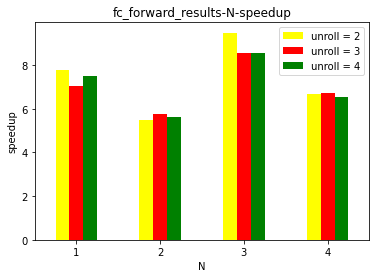

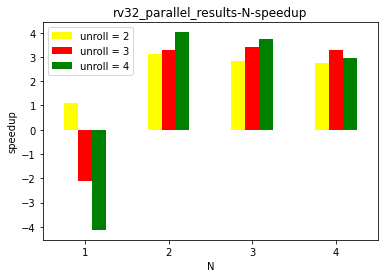

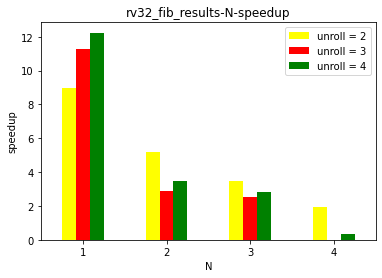

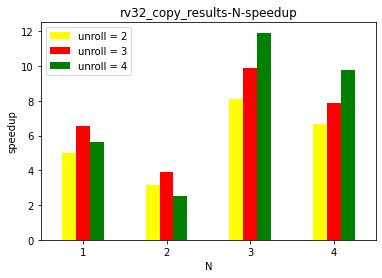

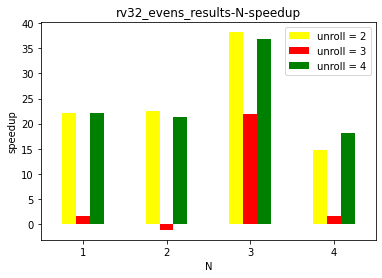

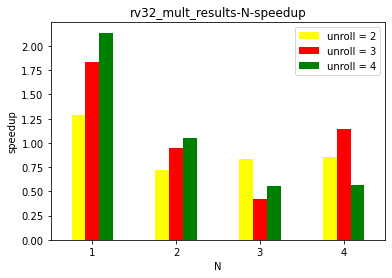

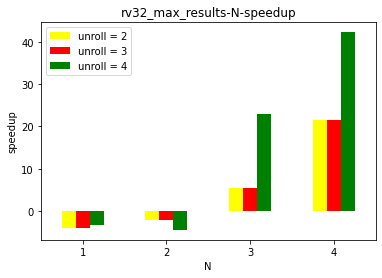

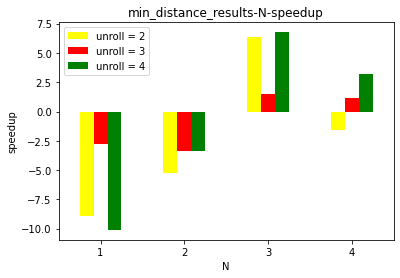

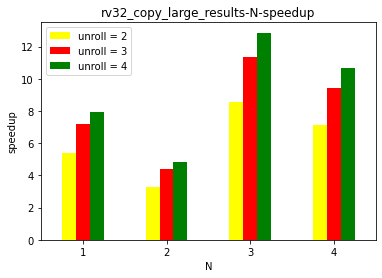

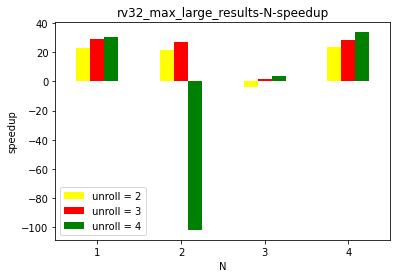

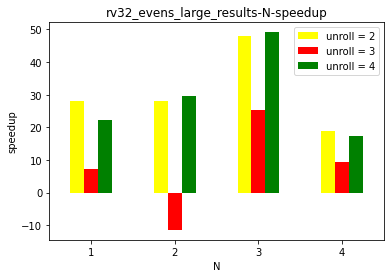

In [37]:
# fc_forward_results = read_csv('fc_forward')
# rv32_parallel_results = read_csv('rv32_parallel')
# rv32_fib_results = read_csv('rv32_fib')
# rv32_copy_results = read_csv('rv32_copy')
# rv32_evens_results = read_csv('rv32_evens')
# rv32_mult_results = read_csv('rv32_mult')
# rv32_max_results = read_csv('rv32_max')
# min_distance_results = read_csv('min_distance')

x_key = 'N'
y_key = 'speedup'

plt_bar_chart(fc_forward_results, f'fc_forward_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_parallel_results, f'rv32_parallel_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_fib_results, f'rv32_fib_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_copy_results, f'rv32_copy_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_evens_results, f'rv32_evens_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_mult_results, f'rv32_mult_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_max_results, f'rv32_max_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(min_distance_results, f'min_distance_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)

plt_bar_chart(rv32_copy_large_results, f'rv32_copy_large_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_max_large_results, f'rv32_max_large_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)
plt_bar_chart(rv32_evens_large_results, f'rv32_evens_large_results-{x_key}-{y_key}', x_key=x_key, y_key=y_key)


## Scatter Plots

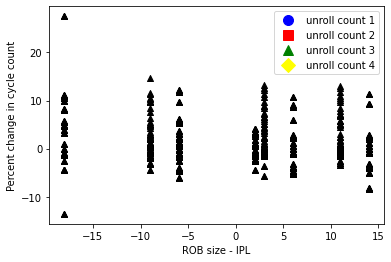

In [38]:
import matplotlib.lines as mlines

def build_scatter_table(dfs):
    result = pd.concat(dfs)
    result['robilp'] = result['ROB size'] - result['IPL']
    result = result[result['Optimization Lvl'] == 8]    
#     result = result.groupby(['robilp'] + OPTIMIZATIONS + ['ROB size']).mean()
#     result = result.reset_index()
    return result

scatter_table = build_scatter_table([fc_forward_results, rv32_parallel_results, rv32_fib_results])



symbols = ['', u'o', u's', '^', 'D']
colors = ['', u'yellow', u'black', 'black', 'black']


for index, row in scatter_table.iterrows():
    x = row['robilp']
    y = row['speedup']
    rob_size = int(row['ROB size'])
    uc = int(row['Unrolls'])
    if uc == 3:
        plt.scatter(x, y, marker=symbols[uc], c=colors[uc])


plt.xlabel("ROB size - IPL")
plt.ylabel("Percent change in cycle count")


rob_size_1 = scatter_table['ROB size'].unique()[0]
rob_size_2 = scatter_table['ROB size'].unique()[1]

uc1 = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          markersize=10, label= f'unroll count 1')

uc2 = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
                          markersize=10, label= f'unroll count 2')

uc3 = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=10, label= f'unroll count 3')

uc4 = mlines.Line2D([], [], color='yellow', marker='D', linestyle='None',
                          markersize=10, label= f'unroll count 4')

plt.legend(handles=[uc1, uc2, uc3, uc4])

plt.show()

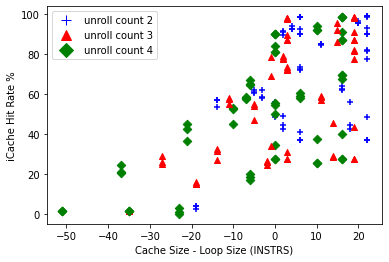

In [39]:
import matplotlib.lines as mlines

def build_scatter_table(dfs):
    result = pd.concat(dfs)
    result['cacheilp'] = 2 * result['Cache Size'] - result['IPL']
    result = result[result['Optimization Lvl'] == 8]    
    return result

scatter_table = build_scatter_table([fc_forward_results, rv32_parallel_results, rv32_fib_results, rv32_copy_results, rv32_mult_results, rv32_max_results, min_distance_results, rv32_copy_large_results, rv32_evens_large_results, rv32_max_large_results])
# scatter_table = build_scatter_table([fc_forward_results])



symbols = ['', u'o', u'+', '^', 'D']
# colors = ['', u'black', u'black', 'black', 'black']
colors = ['red', 'yellow', u'blue', u'red', 'green']


for index, row in scatter_table.iterrows():
    x = row['cacheilp']
    y = row['icache_pct']
    cache_size = int(row['Cache Size'])
    uc = int(row['Unrolls'])
    if row['N'] == 3 and int(row['Memory Latency']) == 1000 and int(row['Cache Size']) != 64 and int(row['Branch Type']) == 1:
        if abs(float(y)) < 100 and uc != 1: 
            plt.scatter(x, y, marker=symbols[uc], c=colors[uc])


plt.xlabel("Cache Size - Loop Size (INSTRS)")
plt.ylabel("iCache Hit Rate %")


# uc1 = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
#                           markersize=10, label= f'unroll count 1')

uc2 = mlines.Line2D([], [], color='blue', marker='+', linestyle='None',
                          markersize=10, label= f'unroll count 2')

uc3 = mlines.Line2D([], [], color='red', marker='^', linestyle='None',
                          markersize=10, label= f'unroll count 3')

uc4 = mlines.Line2D([], [], color='green', marker='D', linestyle='None',
                          markersize=10, label= f'unroll count 4')

plt.legend(handles=[uc2, uc3, uc4])
plt.savefig('figs/cache-ilpvicache-n3-mem-1000.pdf')

plt.show()


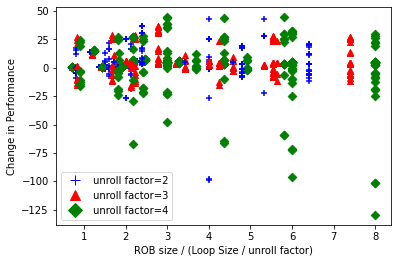

In [43]:
import matplotlib.lines as mlines

def build_scatter_table(dfs):
    result = pd.concat(dfs)
    result['robdilp'] = result['ROB size']  / result['IPL']
    result = result[result['Optimization Lvl'] == 8]    
    return result

scatter_table = build_scatter_table([fc_forward_results, rv32_parallel_results, rv32_fib_results, rv32_copy_results, rv32_mult_results, rv32_max_results, min_distance_results, rv32_copy_large_results, rv32_evens_large_results, rv32_max_large_results])
# scatter_table = build_scatter_table([rv32_fib_results])



symbols = ['', 'o', '+', '^', 'D']
# colors = ['', u'black', u'black', 'black', 'black']
colors = ['', 'yellow', 'blue', 'red', 'green']


for index, row in scatter_table.iterrows():
    y = row['speedup']
    cache_size = int(row['Cache Size'])
    uc = int(row['Unrolls'])
    x = row['robdilp'] * uc    
    if row['N'] == 2 and int(row['Memory Latency']) == 100 and uc != 1:# and int(row['Cache Size']) == 64:
        plt.scatter(x, y, marker=symbols[uc], c=colors[uc])


plt.xlabel("ROB size / (Loop Size / unroll factor)")
plt.ylabel("Change in Performance")


# uc1 = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
#                           markersize=10, label= f'unroll factor=1')

uc2 = mlines.Line2D([], [], color='blue', marker='+', linestyle='None',
                          markersize=10, label= f'unroll factor=2')

uc3 = mlines.Line2D([], [], color='red', marker='^', linestyle='None',
                          markersize=10, label= f'unroll factor=3')

uc4 = mlines.Line2D([], [], color='green', marker='D', linestyle='None',
                          markersize=10, label= f'unroll factor=4')

plt.legend(handles=[uc2, uc3, uc4])

plt.savefig('figs/rob-notusedgraph.pdf')
plt.show()

In [ ]:
import matplotlib.lines as mlines
from sklearn.metrics import r2_score



# scatter_table = build_scatter_table([fc_forward_results, rv32_parallel_results, rv32_fib_results, rv32_copy_results, rv32_mult_results, rv32_max_results, min_distance_results, rv32_copy_large_results, rv32_evens_large_results, rv32_max_large_results])
scatter_table = min_distance_results


xs = []
ys = []

for index, row in scatter_table.iterrows():
    y = row['speedup']
    x = row['branch_pct']
    

    if row['N'] == 2 and int(row['Memory Latency']) == 100 and int(row['Unrolls']) != 1:# and int(row['Cache Size']) == 64:
        if int(row['Branch Type']) == 1:
            xs.append(x)
            ys.append(y)        
            plt.scatter(x, y, marker='+', c='blue')
        if int(row['Branch Type']) == 2: 
            xs.append(x)
            ys.append(y)        
            plt.scatter(x, y, marker='^', c='red')
        if int(row['Branch Type']) == 3:
            xs.append(x)
            ys.append(y)        
            plt.scatter(x, y, marker='D', c='green')            
        
        
uc2 = mlines.Line2D([], [], color='blue', marker='+', linestyle='None',
                          markersize=10, label= f'G-Share')

uc3 = mlines.Line2D([], [], color='red', marker='^', linestyle='None',
                          markersize=10, label= f'Local History')

uc4 = mlines.Line2D([], [], color='green', marker='D', linestyle='None',
                          markersize=10, label= f'Local Bimodal')

plt.legend(handles=[uc2, uc3, uc4])        

plt.xlabel("Branch Predictor Hit Rate")
plt.ylabel("Change in Performance")

plt.savefig(f'figs/branch-pred-perf.pdf')

plt.show()

In [ ]:
import matplotlib.lines as mlines
from sklearn.metrics import r2_score
import numpy as np



scatter_table = build_scatter_table([fc_forward_results, rv32_parallel_results, rv32_fib_results, rv32_copy_results, rv32_mult_results, rv32_max_results, min_distance_results]) # rv32_copy_large_results, rv32_evens_large_results, rv32_max_large_results])
# scatter_table = min_distance_results


xs = []
ys = []

symbols = ['', 'o', '+', '^', 'D']
colors = ['', 'yellow', u'blue', u'red', 'green']

for index, row in scatter_table.iterrows():
    y = row['branch_pct']
    uc = row['Unrolls']
    x = np.log(row['N-iterations'])

    if int(row['Branch Type']) == 1 and int(row['Memory Latency']) == 100 and int(row['Cache Size']) == 64 and int(row['N']) == 3:
        xs.append(x)
        ys.append(y)
        plt.scatter(x, y, marker='o', c='black')
#         plt.scatter(x, y, marker=markers[uc], c=colors[uc])



plt.xlabel("log Number of Iterations")
plt.ylabel("Branch Predictor Hit Rate")

plt.savefig(f'figs/unroll-branch-pred-log.pdf')


plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
X = np.array(xs).reshape(-1, 1)
print(X.shape)
y = np.array(ys)
print(y.shape)
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
print(r2_score(ys, y_pred))

In [24]:
def max_unroll_heuristic():
    return 4

def n_unroll_heuristic(n):
    return n

def min_cache_heuristic(cache_size, ipl): # (32, 64, 12)
    val = cache_size * 2
    return int(val/ipl)

def min_rob_heuristic(rob_size, ipl): # (32, 64, 12)
    val = rob_size
    return int(val/ipl)

def min_rob_cache_heuristic(rob_size, cache_size, ipl): # (32, 64, 12)
    val = min(rob_size, cache_size * 2)
    return int(val/ipl)

In [25]:
# iterate through each hardware
# select based on the heuristic
# build table
result = pd.concat([fc_forward_results, rv32_parallel_results, rv32_fib_results, rv32_copy_results, rv32_mult_results, rv32_max_results, min_distance_results])
result['hardware_id'] = result[HARDWARE_COLUMNS].astype(str).agg('-'.join, axis=1)   
result = result[result['Optimization Lvl'] == 8]
result
hardware_configs = [] 
for id in result['hardware_id'].unique():
    hardware_configs.append(id)


In [26]:
heuristic_res = {'configs': hardware_configs, 'max_unroll': [], 'n_unroll': [], 'min_rob_cache': [], 'min_cache': [], 'oracle': [], 'min_rob': []}
for idx, hid in enumerate(result['hardware_id'].unique()):
    max_unroll_vals = []
    n_unroll_vals = []
    min_caches = []
    min_robs = []
    oracles = []
    min_rob_caches = []
    for test_case in result['Case name'].unique():
        rows = result[(result['hardware_id'] == hid) & (result['Case name'] == test_case)]
        if len(rows[(rows['Unrolls'] == n_unroll_heuristic(n))]) == 0:
            continue
        
        n = rows['N'].unique()[0]
        rob_size = rows['ROB size'].unique()[0]
        cache_size = rows['Cache Size'].unique()[0]        
        
        max_unroll = float(rows[(rows['Unrolls'] == 4)]['speedup'])

        n_unroll = float(rows[(rows['Unrolls'] == n_unroll_heuristic(n))]['speedup'])
        
        max_unroll_vals.append(max_unroll)
        n_unroll_vals.append(n_unroll)        
        
        
        oracle = 0
        min_cache = 999
        min_rob = 999
        min_rob_cache = 999
        
        
        for uc in range(1, 5):
            row = rows[(rows['Unrolls'] == uc)]
            try:
                ipl = int(row['IPL'])
            except:
                print('skipping row: ', row)
                continue
            if float(row['speedup']) > oracle:
                oracle = float(row['speedup'])
            min_cache = min(min_cache, min_cache_heuristic(cache_size, ipl))
            min_rob = min(min_rob, min_rob_heuristic(rob_size, ipl))
            min_rob_cache = min(min_rob, min_rob_cache_heuristic(rob_size, cache_size, ipl))
            
            
        
        if min_cache < 1:
            min_cache = 1
        if min_cache > 4:
            min_cache = 4
            
        if min_rob < 1:
            min_rob = 1
        if min_rob > 4:
            min_rob = 4            
            
        if min_rob_cache < 1:
            min_rob_cache = 1
        if min_rob_cache > 4:
            min_rob_cache = 4            
            
            
        oracles.append(oracle)
        min_caches.append(float(rows[(rows['Unrolls'] == min_cache)]['speedup']))
        min_robs.append(float(rows[(rows['Unrolls'] == min_rob)]['speedup']))
        min_rob_caches.append(float(rows[(rows['Unrolls'] == min_rob_cache)]['speedup']))
            
        
    heuristic_res['max_unroll'].append(float(sum(max_unroll_vals)/len(max_unroll_vals)))
    heuristic_res['n_unroll'].append(float(sum(n_unroll_vals)/len(n_unroll_vals)))
    heuristic_res['oracle'].append(float(sum(oracles)/len(oracles)))    
    heuristic_res['min_cache'].append(float(sum(min_caches)/len(min_caches)))    
    heuristic_res['min_rob'].append(float(sum(min_robs)/len(min_robs)))    
    heuristic_res['min_rob_cache'].append(float(sum(min_rob_caches)/len(min_rob_caches)))    

In [27]:
for key in heuristic_res.keys():
    print(f'{key}: {len(heuristic_res[key])}')

configs: 216
max_unroll: 216
n_unroll: 216
min_rob_cache: 216
min_cache: 216
oracle: 216
min_rob: 216


In [28]:
pd.DataFrame(heuristic_res).mean()

/var/folders/c5/hvq9jlyn2j7bfmdf2yh88djr0000gn/T/ipykernel_96934/1776675499.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame(heuristic_res).mean()


max_unroll       1.364287
n_unroll         1.996558
min_rob_cache    0.215089
min_cache        1.754878
oracle           5.504001
min_rob          0.206912
dtype: float64

## Section 1 Figures


In [ ]:
df = aggregate_results([rv32_copy_results, rv32_copy_large_results, rv32_parallel_results]) # DOALL
# df = aggregate_results([fc_forward_results, rv32_evens_results, rv32_evens_large_results, rv32_max_results, rv32_max_large_results]) #DOACROSS
# df = aggregate_results([min_distance_results, rv32_fib_results, rv32_mult_results]) #SERIALS

df = df.reset_index()
df['hardware_id']= df[HARDWARE_COLUMNS].astype(str).agg('-'.join, axis=1)    

In [ ]:
colors = ['black','yellow', 'blue', 'red', 'green']
markers = ['o', 'o', '+', 'D', '^']

for idx, hardware_id in enumerate(df['hardware_id'].unique()):
    x = idx
    for uc in range(2,5):
        y = df[(df['hardware_id'] == hardware_id) & (df['Unrolls'] == uc)]['speedup']
        if abs(float(y)) < 300:
            plt.scatter(x, y, marker=markers[uc], c=colors[uc])
        

    



plt.xlabel("Hardware Config ID")
plt.ylabel("Speedup %")



uc2 = mlines.Line2D([], [], color='blue', marker='+', linestyle='None',
                          markersize=10, label= f'unroll count 2')

uc3 = mlines.Line2D([], [], color='red', marker='D', linestyle='None',
                          markersize=10, label= f'unroll count 3')

uc4 = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=10, label= f'unroll count 4')

plt.legend(handles=[uc2, uc3, uc4])

plt.savefig(f'figs/hardware-speedup-doall.pdf')

plt.show()